## Stock Price Forecasting Using LSTM

#### The purpose of this project is to use LSTM method to predict stock price of Apple Inc..

In [1]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
def actf(z): 
    return 1 / (1 + np.exp(-z))

def actfder(z): 
    return z*(1-z)

def acttander(z): 
    return 1 - z * z

In [3]:
class Weights_init:
    # initialize gate parameters. neurond is the dimension of cell state, dimensionx is the dimension of input
    def __init__(self, neurond, dimensionx):
        self.neurond = neurond
        self.dimensionx = dimensionx
        # dimensionsum is the dimension of concatenate 
        dimensionsum = dimensionx + neurond
        # initialize weights matrices
        self.inputweight = np.random.rand(neurond, dimensionsum)*0.2-0.1 #initialize the weights of input gate(i)
        self.forgetweight = np.random.rand(neurond, dimensionsum)*0.2-0.1  #initialize the weights of forget gate(f)
        self.outputweight = np.random.rand(neurond, dimensionsum)*0.2-0.1 #initialize the weight output gate(o)
        self.gateweight = np.random.rand(neurond, dimensionsum)*0.2-0.1 #initialize the weight of Input Modulation gate(g)
        # initialize offset terms
        self.inputoffset = np.random.rand(neurond)*0.2-0.1  #initialize the offset(bias) of input gate(i)
        self.forgetoffset = np.random.rand(neurond)*0.2-0.1  #initialize the offset(bias) of forget gate(f)
        self.outputoffset = np.random.rand(neurond)*0.2-0.1  #initialize the offset(bias) of output gate(o)
        self.gateoffset = np.random.rand(neurond)*0.2-0.1  #initialize the offset(bias) of input modulation gate(g)
        # derivation of loss function about weights and offset terms
        self.inputweightder = np.zeros((neurond, dimensionsum)) #initialize the derivarion of weights of input gate(i) to 0
        self.forgetweightder = np.zeros((neurond, dimensionsum)) #initialize the derivarion of weights of forget gate(f) to 0
        self.outputweightder = np.zeros((neurond, dimensionsum)) #initialize the derivarion of weights of output gate(o) to 0
        self.gateweightder = np.zeros((neurond, dimensionsum)) #initialize the derivarion of weights of input modulation gate(g) to 0
        self.inputoffsetder = np.zeros(neurond) #initialize the derivarion of offset of input gate(i) to 0
        self.forgetoffsetder = np.zeros(neurond) #initialize the derivarion of offset of forget gate(f) to 0
        self.outputoffsetder = np.zeros(neurond) #initialize the derivarion of offset of output gate(o) to 0
        self.gateoffsetder = np.zeros(neurond) #initialize the derivarion of offset of input modulation gate(g) to 0
    # Update weights and offset, alpha is the learning rate
    def weight_update(self, alpha):
        self.gateweight -= alpha * self.gateweightder
        self.inputweight -= alpha * self.inputweightder
        self.forgetweight -= alpha * self.forgetweightder
        self.outputweight -= alpha * self.outputweightder
        self.gateoffset -= alpha * self.gateoffsetder
        self.inputoffset -= alpha * self.inputoffsetder
        self.forgetoffset -= alpha * self.forgetoffsetder
        self.outputoffset -= alpha * self.outputoffsetder
        # reset the derivation of weights and offset terms as 0
        self.gateweightder = np.zeros_like(self.gateweight)
        self.inputweightder = np.zeros_like(self.inputweight) 
        self.forgetweightder = np.zeros_like(self.forgetweight) 
        self.outputweightder = np.zeros_like(self.outputweight) 
        self.gateoffsetder = np.zeros_like(self.gateoffset)
        self.inputoffsetder = np.zeros_like(self.inputoffset) 
        self.forgetoffsetder = np.zeros_like(self.forgetoffset) 
        self.outputoffsetder = np.zeros_like(self.outputoffset)

In [4]:
class Gates_init:
    # initialize gate values
    def __init__(self, neurond, dimensionx):
        self.input = np.zeros(neurond) #initialize all gate values to 0
        self.forget = np.zeros(neurond)
        self.output = np.zeros(neurond)
        self.gate = np.zeros(neurond)
        self.neuron = np.zeros(neurond) #initialize the cell state(c) to 0
        self.houtput = np.zeros(neurond) #initialize output(h) to 0
        self.end_neurond_d = np.zeros_like(self.neuron)
        self.end_houput_d = np.zeros_like(self.houtput)

In [5]:
class NeuronLstm:
    def __init__(self, inputp, instance):
        self.inputp = inputp 
        self.instance = instance 
        self.connect = None #initialize no concatenate between input and cell state

    def forward_pass(self, z, neuron_first = None, houtput_first = None): #forward pass 
        if neuron_first is None: neuron_first = np.zeros_like(self.instance.neuron) #if neuron_first is the first cell
        if houtput_first is None: houtput_first = np.zeros_like(self.instance.houtput) #if houtput_first is the first output
        self.neuron_first = neuron_first #store the data
        self.houtput_first = houtput_first

        connect = np.hstack((z,  houtput_first)) # concatenate the input z and the previous output
        self.instance.input = actf(np.dot(self.inputp.inputweight, connect) + self.inputp.inputoffset) #calculate input gate value
        self.instance.forget = actf(np.dot(self.inputp.forgetweight, connect) + self.inputp.forgetoffset) #calculate forget gate value
        self.instance.output = actf(np.dot(self.inputp.outputweight, connect) + self.inputp.outputoffset) #calculate output gate value
        self.instance.gate = np.tanh(np.dot(self.inputp.gateweight, connect) + self.inputp.gateoffset) #calculate gate gate value 
        self.instance.neuron = self.instance.gate * self.instance.input + neuron_first * self.instance.forget #calculate internal state
        self.instance.houtput = self.instance.neuron * self.instance.output #store the output h(t)=c(t)*o(t)

        self.connect = connect #store the concatenate of input and internal state
    
    def back_prop(self, secondhc, seconddc): #backpropagation through time to update parameters(W, b)
        dc = self.instance.output * secondhc + seconddc


        # derivation  of the input
        self.inputp.inputweightder += np.outer(actfder(self.instance.input) * self.instance.gate * dc, self.connect) #derivation of input gate weight(Wi)=(dlt/dh + dL(t+1)/dh)*(dh/ds)*(ds/di)*(di/dWi)
        self.inputp.forgetweightder += np.outer(actfder(self.instance.forget) * self.neuron_first * dc, self.connect) #derivation of forget gate weight(Wf)=(dlt/dh + dL(t+1)/dh)*(dh/ds)*(ds/df)*(df/dWf)
        self.inputp.outputweightder += np.outer(actfder(self.instance.output) * self.instance.neuron * secondhc, self.connect)#derivation of output gate weight(Wo)=(dlt/dh + dL(t+1)/dh)*(dh/do)*(do/dWo)
        self.inputp.gateweightder += np.outer(acttander(self.instance.gate) * self.instance.input * dc, self.connect)#derivation of gate gate weight(Wg)=(dlt/dh + dL(t+1)/dh)*(dh/ds)*(ds/dg)*(dg/dWg)
        self.inputp.inputoffsetder += actfder(self.instance.input) * self.instance.gate * dc #derivation of input gate offset(bi)=(dlt/dh + dL(t+1)/dh)*(dh/ds)*(ds/di)*(di/dbi)
        self.inputp.forgetoffsetder += actfder(self.instance.forget) * self.neuron_first * dc #derivation of forget gate weight(Wf)=(dlt/dh + dL(t+1)/dh)*(dh/ds)*(ds/df)*(df/dbf)      
        self.inputp.outputoffsetder += actfder(self.instance.output) * self.instance.neuron * secondhc #derivation of output gate offset(Wo)=(dlt/dh + dL(t+1)/dh)*(dh/do)*(do/dbo)
        self.inputp.gateoffsetder += acttander(self.instance.gate) * self.instance.input * dc #derivation of gate gate weight(Wg)=(dlt/dh + dL(t+1)/dh)*(dh/ds)*(ds/dg)*(dg/dbg)

        # calculate the next derivation
        connectder = np.zeros_like(self.connect)
        connectder += np.dot(self.inputp.inputweight.T, actfder(self.instance.input) * self.instance.gate * dc )
        connectder += np.dot(self.inputp.forgetweight.T, actfder(self.instance.forget) * self.neuron_first * dc )
        connectder += np.dot(self.inputp.outputweight.T, actfder(self.instance.output) * self.instance.neuron * secondhc)
        connectder += np.dot(self.inputp.gateweight.T, acttander(self.instance.gate) * self.instance.input * dc)

        # save all derivation values
        self.instance.end_neuron_d = dc * self.instance.forget
        self.instance.end_houtput_d = connectder[self.inputp.dimensionx:]


In [6]:
class Lstm(): #do forward pass
    def __init__(self, coefficient):
        self.coefficient = coefficient
        self.vectorlstm = []
        self.vectorin = [] #initialize the input as a empty vector

    def deficit_fun(self, vectorout, deficit_level):
        assert len(vectorout) == len(self.vectorin)
        length = len(self.vectorin) - 1  # assign time steps
        deficit = deficit_level.deficit(self.vectorlstm[length].instance.houtput, vectorout[length]) #calculate loss value of the last step
        houtputdif = deficit_level.end_d(self.vectorlstm[length].instance.houtput, vectorout[length]) #derivation of loss with respect to output of the last step
        neurondif = np.zeros(self.coefficient.neurond) #derivation of loss with respect to cell of the last step which is 0
        self.vectorlstm[length].back_prop(houtputdif, neurondif) #update the parameters of last step
        length -= 1

        while length >= 0: #update the parameters of t-1 steps
            deficit += deficit_level.deficit(self.vectorlstm[length].instance.houtput, vectorout[length])
            houtputdif = deficit_level.end_d(self.vectorlstm[length].instance.houtput, vectorout[length])
            houtputdif += self.vectorlstm[length + 1].instance.end_houtput_d
            neurondif = self.vectorlstm[length + 1].instance.end_neuron_d
            self.vectorlstm[length].back_prop(houtputdif, neurondif)
            length -= 1 

        return deficit

    def vectorin_empty(self):
        self.vectorin = []

    def vectorin_append(self, z):
        self.vectorin.append(z)
        if len(self.vectorin) > len(self.vectorlstm):
            instancelstm = Gates_init(self.coefficient.neurond, self.coefficient.dimensionx)
            self.vectorlstm.append(NeuronLstm(self.coefficient, instancelstm))
        
        length = len(self.vectorin) - 1
        if length == 0:
            self.vectorlstm[length].forward_pass(z)
        else:
            neuron_first = self.vectorlstm[length - 1].instance.neuron
            houtput_first = self.vectorlstm[length - 1].instance.houtput
            self.vectorlstm[length].forward_pass(z, neuron_first, houtput_first)


In [7]:
class deficit_def:
    """
    Computes square loss with first element of hidden layer array.
    """
    @classmethod
    def deficit(self, forecast, true):
        return (forecast[0] - true) * (forecast[0] - true)

    @classmethod
    def end_d(self, forecast, true):
        substract = np.zeros_like(forecast)
        substract[0] = 2 * (forecast[0] - true)
        return substract

In [8]:
#import Apple stock price dataset from Yahoo finance (up to date)
apple_stock = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=974764800&period2=1605916800&interval=1d&events=history&includeAdjustedClose=true', date_parser = True)
apple_stock.tail()

apple_stock.shape[0]

5032

In [9]:
apple_stock.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-21,0.342634,0.348214,0.334821,0.335938,0.289365,301952000
1,2000-11-22,0.335938,0.341518,0.328125,0.330357,0.284557,280532000
2,2000-11-24,0.336775,0.348214,0.335938,0.344866,0.297055,160932800
3,2000-11-27,0.354911,0.356027,0.330357,0.333705,0.287441,258792800
4,2000-11-28,0.333705,0.339286,0.320313,0.321987,0.277348,269124800


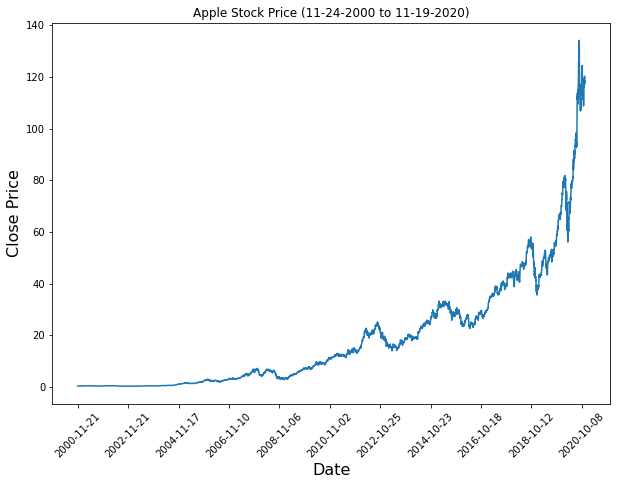

In [11]:
#plot to overview Apple stock close price (11-24-2000 to 11-19-2020)
np.random.rand(3)
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.plot(range(apple_stock.shape[0]),apple_stock['Close'])
plt.xticks(range(0,apple_stock.shape[0],500),apple_stock['Date'].loc[::500],rotation=45)
plt.title('Apple Stock Price (11-24-2000 to 11-19-2020)')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Close Price',fontsize=16)
plt.show()


In [12]:
#prepare training data
appletrain = apple_stock[apple_stock['Date']<'2018-01-01'].copy()
appletrain

apple_stock_test = apple_stock[(apple_stock['Date']>='2018-01-01') & (apple_stock['Date']<='2020-11-19')].copy()
apple_stock_test

#remove the unused features
trainapple = appletrain.drop(['Date', 'Adj Close'], axis = 1)
trainapple.head()

,Open,High,Low,Close,Volume
0,0.342634,0.348214,0.334821,0.335938,301952000
1,0.335938,0.341518,0.328125,0.330357,280532000
2,0.336775,0.348214,0.335938,0.344866,160932800
3,0.354911,0.356027,0.330357,0.333705,258792800
4,0.333705,0.339286,0.320313,0.321987,269124800


In [13]:
#standardize the trainning data by MinMaxScaler 
scaler = MinMaxScaler()
trainapple= scaler.fit_transform(trainapple)
trainapple

#create a list for trainingx and trainingy respectively
trainingx = []
trainingy = []

In [15]:
#promote user input parameters
timesteps = int(input("Please enter the time steps: "))
neurond = int(input("Please enter the dimensions: ")) # the dimension of output(h)
numberofepoch = int(input("Please enter epoch  number : "))
alpha = float(input("Please enter the learning rate: "))

Please enter the time steps: 10
Please enter the dimensions: 100
Please enter epoch  number : 20
Please enter the learning rate: 0.01


In [16]:
for j in range(timesteps, trainapple.shape[0]):
  trainingx.append(trainapple[j-timesteps:j])
  trainingy.append(trainapple[j-timesteps+1:j+1, 0])

In [17]:
#transform trainingx, trainingy  into numpy array
trainingx, trainingy = np.array(trainingx), np.array(trainingy)
trainingx.shape, trainingy.shape

((4293, 10, 5), (4293, 10))

In [18]:
dimensionx = 5 #the dimension of input
coefficient = Weights_init(neurond, dimensionx) #the weights and offset
lstm_web = Lstm(coefficient)

In [19]:
for epoch in range(1,numberofepoch): #without batch
#    print("iter", "%2s" % str(epoch), end=": ")
    for cur_iter in range(len(trainingy)): # the number of sample
      vectorout = trainingy[cur_iter,]
      input_val = trainingx[cur_iter,]
      for h in range(len(vectorout)): # number of time step of each sample
        lstm_web.vectorin_append(input_val[h]) # calculate all values of forward pass

      deficit = lstm_web.deficit_fun(vectorout, deficit_def)
#      print("loss: ", "%.3e" % loss)
#     print("iters: ", "%.3e" % cur_iter)
#      print("epoch: ", "%.3e" % epoch)
      coefficient.weight_update(alpha) #use each sample to update weights in backpropagation
      lstm_web.vectorin_empty()

In [20]:
#prepare the test data
test_apple_stock = apple_stock_test.drop(['Date', 'Adj Close'], axis = 1)
test_apple_stock.head()
scaler = MinMaxScaler()
test_apple_stock = scaler.fit_transform(test_apple_stock)
test_apple_stock
testingx = []
testingy = []
for j in range(timesteps, test_apple_stock.shape[0]):
  testingx.append(test_apple_stock[j-timesteps:j])
  testingy.append(test_apple_stock[j-timesteps+1:j+1, 0])
testingx, testingy = np.array(testingx), np.array(testingy)
testingx.shape, testingy.shape

((718, 10, 5), (718, 10))

In [21]:
#calculate the prediction
y_pre = []
for cur_iter in range(len(testingy)):
    vectorout = testingy[cur_iter,]
    input_val = testingx[cur_iter,]
    for h in range(len(vectorout)):
      lstm_web.vectorin_append(input_val[h])

    y_pre.append(lstm_web.vectorlstm[len(vectorout)-1].instance.houtput[0])
    lstm_web.vectorin_empty()


In [22]:
scaler.scale_

#get the scale which is used to scale up  forecasty and testingy
scale = 1/9.84300438e-03 
scale

#scale up forecasty and testingy to original $ scale
forecasty_scale = [i * scale for i in y_pre ]
testingy_scale=testingy[:,timesteps-1]*scale

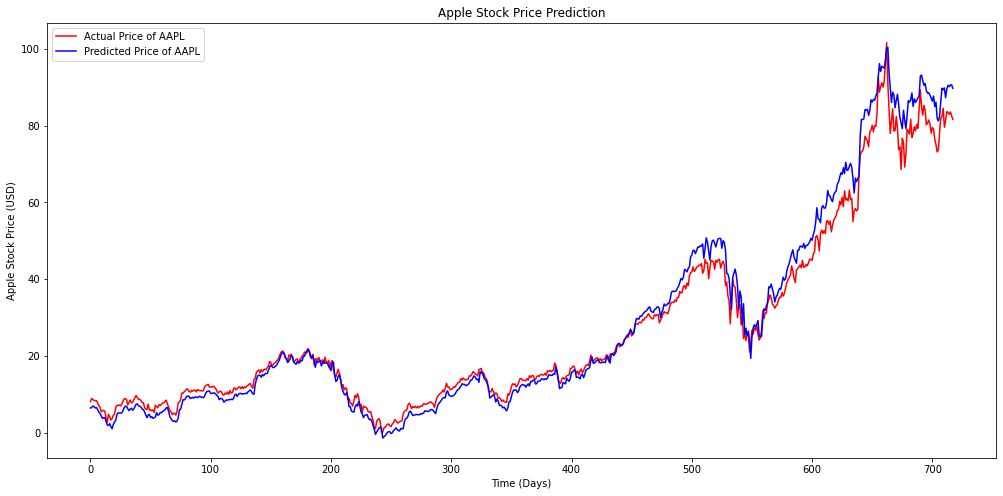

In [23]:
# Visualising the results of predict and actual price
plt.figure(figsize=(17,8))
plt.plot(testingy_scale, color = 'red', label = 'Actual Price of AAPL')
plt.plot(forecasty_scale, color = 'blue', label = 'Predicted Price of AAPL')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time (Days)')
plt.ylabel('Apple Stock Price (USD)')
plt.legend()
plt.show()

In [24]:
#calculate RMSE for the stock price prediction model

RMSE=mean_squared_error(testingy_scale, forecasty_scale)
print()
print("RMSE: ", RMSE)


RMSE:  13.55251367792292
